## Uncertainty estimation plots

In [2]:
%matplotlib inline

import os
import sys
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
import pickle
sys.path.append('../src/')
import SimpleITK as sitk
from multiprocessing import Pool
import glob
import medvis
from skimage import measure
import matplotlib.patches as mpatches
from matplotlib import gridspec
from utils import *
import seaborn as sns




## Example for comparision of different uncertainty estimation methods.

In [20]:
## directorys for probability maps 

DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"

PMAPS = [
join(NNUNET_PMAPS,'f0'),
join(NNUNET_PMAPS,'f0_tta'),
join(DROP2_PMAPS,'f0_mc10_tta')
,join(NNUNET_PMAPS,'f01234_tta') #,join(NNUNET_PMAPS,'f0123456789_tta')
,join(DROP2_PMAPS,'f0_tta_snap')
,join(DROP2_PMAPS,'f01234_mc10_tta_snap')
,join(PH_PMAP,'f01234_tta'),
]

## directorys for error maps 
DROP2_ERRORS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/error_region/Task901_AUH/imagesTs"
NNUNET_ERRORS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/error_region/Task901_AUH/imagesTs"
PH_ERRORS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/error_region/Task901_AUH/imagesTs"
PH_GAMM_ERRORS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/error_region/Task901_AUH/imagesTs"

ERRORS = [
join(NNUNET_ERRORS,'f0'),
join(NNUNET_ERRORS,'f0_tta'),
join(DROP2_ERRORS,'f0_mc10_tta')
,join(NNUNET_ERRORS,'f01234_tta') #,join(NNUNET_ERRORS,'f0123456789_tta')
,join(DROP2_ERRORS,'f0_tta_snap')
,join(DROP2_ERRORS,'f01234_mc10_tta_snap')
,join(PH_ERRORS,'f01234_tta'),
]

## directorys for umaps  
DROP2_UMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/umaps/Task901_AUH/imagesTs"
NNUNET_UMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/umaps/Task901_AUH/imagesTs"
PH_UMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/umaps/Task901_AUH/imagesTs"
PH_GAMM_UMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/umaps/Task901_AUH/imagesTs"

UMAPS = [
join(NNUNET_UMAPS,'f0'),
join(NNUNET_UMAPS,'f0_tta'),
join(DROP2_UMAPS,'f0_mc10_tta')
,join(NNUNET_UMAPS,'f01234_tta') #,join(NNUNET_UMAPS,'f0123456789_tta')
,join(DROP2_UMAPS,'f0_tta_snap')
,join(DROP2_UMAPS,'f01234_mc10_tta_snap')
,join(PH_UMAPS,'f01234_tta')

]

groups = ['No TTA','Baseline', 'MC Dropout','Ensemble','Snapshots', "Complex", 'PhiSeg']



In [21]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

class ImageLoader:
    def __init__(self, patient_id, slice_number, direction='axial', bbox=None):
        self.patient_id = patient_id
        self.slice_number = slice_number
        self.direction = direction
        self.bbox = bbox

    def load_image(self, path, image_type):
        if image_type in ['image', 'gt']:
            modality = os.path.basename(path)
            if modality == 'CT':
                path = path.replace('CT', self.patient_id+'_0000')
            elif modality == 'PET':
                path =path.replace('PET', self.patient_id+'_0001')
            elif modality == 'T1w':
                path = path.replace('T1w', self.patient_id+'_0002')
            elif modality == 'T2w':
                path = path.replace('T2w', self.patient_id+'_0003')
            if image_type == 'gt':
                path = join(path, self.patient_id)
            img = self.load_nii(path+'.nii.gz')
        
        elif image_type == 'pmap':
            segmentation_path = join(path, self.patient_id+'.nii.gz')
            pmap_path = segmentation_path.replace('.nii.gz', '.npz')
            segmentation = self.load_nii(segmentation_path)
            pmap = np.load(pmap_path)['softmax'][0]
            pmap = 1- self.extract_slice(pmap)
            if self.bbox:
                segmentation = self.crop_image(segmentation, self.bbox)
                pmap = self.crop_image(pmap, self.bbox)
            return segmentation, pmap
        
        elif image_type == 'umap':
            path = join(path, self.patient_id+'.npz')
            umap = np.load(path)['umap'][0]
            umap =self.extract_slice(umap)
            img = umap
            
        elif image_type == 'error':
            error_t = self.load_nii(join(path, 'GTV-T', self.patient_id+'.nii.gz'))
            error_n = self.load_nii(join(path, 'GTV-N', self.patient_id+'.nii.gz'))
            errors = error_t + error_n
            img = errors
        else:
            raise ValueError("Invalid image_type. Choose from 'image', 'gt', or 'pmap'.")
            
        if self.bbox:
            img = self.crop_image(img, self.bbox)
            
        if image_type != 'pmap':
            return img
            
    def load_nii(self, path):
        img = sitk.ReadImage(path)
        img_array = sitk.GetArrayFromImage(img)
        return self.extract_slice(img_array)

    def load_npz(self, path):
        img_array = np.load(path)['softmax']
        return self.extract_slice(img_array)

    def extract_slice(self, img_array):
        if self.direction.lower() == 'axial':
            slice_img = img_array[self.slice_number, :, :]
        elif self.direction.lower() == 'coronal':
            slice_img = img_array[:, self.slice_number, :]
        elif self.direction.lower() == 'sagittal':
            slice_img = img_array[:, :, self.slice_number]
        else:
            raise ValueError("Invalid direction. Choose from 'axial', 'coronal', or 'sagittal'.")

        return slice_img
    
    def crop_image(self, img, bbox):
            x_min, x_max, y_min, y_max = bbox
            return img[y_min:y_max, x_min:x_max]
        
def dice_coefficient(a, b):
    intersection = np.sum(a * b)
    return np.round(2 * intersection / (np.sum(a) + np.sum(b)), 2)

615 25
214 214
634 27
275 275
569 33
311 311
599 30
378 378
526 21
379 379
482 18
376 376
448 28
643 643


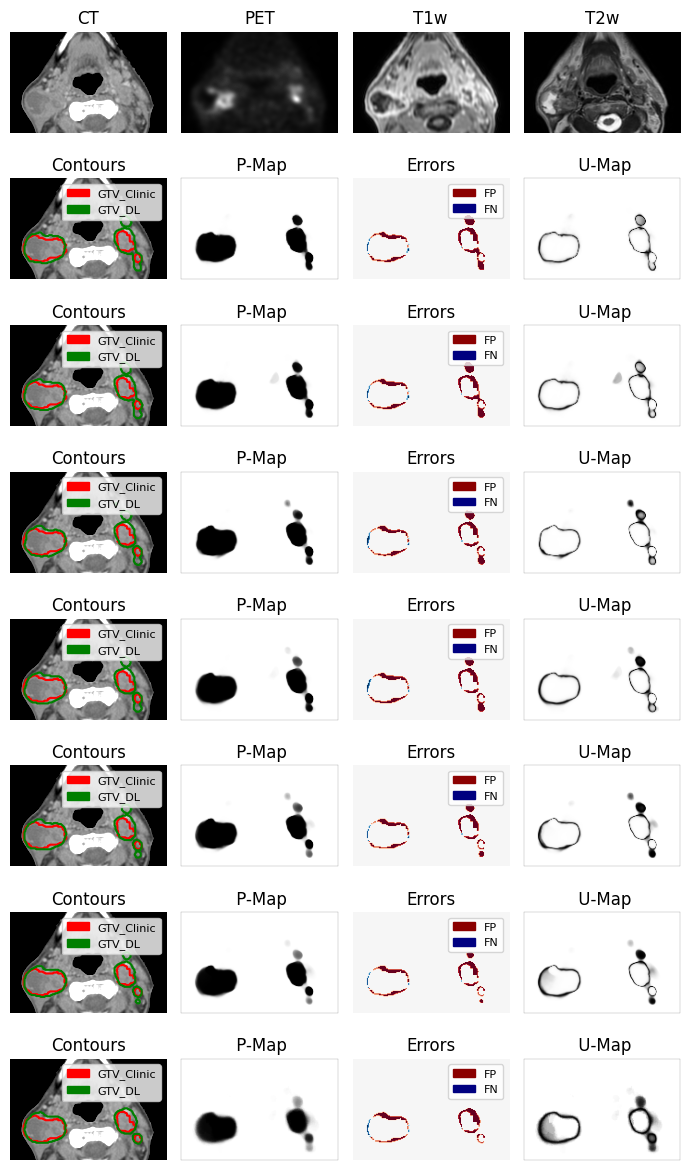

In [31]:

import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Instantiate the ImageLoader class with the desired patient_id, slice_number, and direction
#image_loader = ImageLoader(patient_id='HNCDL_882', slice_number=107, direction='axial')
image_loader = ImageLoader(patient_id='HNCDL_270', slice_number=152
                           , direction='axial', bbox=(40, 210, 50, 160))


raw_path = '/data/jintao/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task901_AUH/'

modality_path = join(raw_path, 'imagesTs')
ground_truth_path = join(raw_path, 'labelsTs')

# Load images
modalities = ['CT', 'PET', 'T1w', 'T2w']
modalities_images = [image_loader.load_image(join(modality_path, modality), 'image') for modality in modalities]
ground_truth = image_loader.load_image(ground_truth_path, 'gt')

p_maps = [image_loader.load_image(path, 'pmap') for path in PMAPS]
errors = [image_loader.load_image(path, 'error') for path in ERRORS]
u_maps = [image_loader.load_image(path, 'umap') for path in UMAPS]

# groups_info = {
#     'No TTA':    {'UE-DSC': 0.75, 'UE-FP': 0.1,  'UE-FN': 0.15},
#     'Baseline':  {'UE-DSC': 0.80, 'UE-FP': 0.08, 'UE-FN': 0.12},
#     'MC Dropout':{'UE-DSC': 0.82, 'UE-FP': 0.07, 'UE-FN': 0.11},
#     'Ensemble':  {'UE-DSC': 0.85, 'UE-FP': 0.05, 'UE-FN': 0.1},
#     'Snapshots': {'UE-DSC': 0.88, 'UE-FP': 0.04, 'UE-FN': 0.08},
#     'Complex':   {'UE-DSC': 0.90, 'UE-FP': 0.03, 'UE-FN': 0.07},
#     'PhiSeg':    {'UE-DSC': 0.3, 'UE-FP': 0.02, 'UE-FN': 0.05},
# }


# Create the plot
fig, axes = plt.subplots(8, 4, figsize=(7, 12))

# First row: Modalities
for idx, modality_img in enumerate(modalities_images):
    if idx == 0:
        axes[0, idx].imshow(modality_img, vmin=-150, vmax=210, cmap='gray')
    else:
        axes[0, idx].imshow(modality_img, cmap='gray')
    axes[0, idx].set_title(modalities[idx])
    axes[0, idx].axis('off')
#fig.text(-0.01, 0.92 , 'Images', fontsize=12, verticalalignment='center', rotation='vertical')
    
# Second to Eighth rows: Ground Truth, P-Map, Errors, and U-Map
for row_idx, (group, p_map, error, u_map) in enumerate(zip(groups, p_maps, errors, u_maps)):
    row = row_idx + 1
    # Add the group name at the left side of each row
    #fig.text(-0.01, 0.833 - 0.123 * row_idx, group, fontsize=12, verticalalignment='top', rotation='vertical')

    # 
    axes[row, 0].imshow(modalities_images[0], vmin=-150, vmax=210, cmap='gray')
    axes[row, 0].set_title(f"Contours")
    axes[row, 0].axis('off')
    
    gt_contour = axes[row, 0].contour(ground_truth, levels=[0.5], colors='r')
    gt_patch = mpatches.Patch(color='red', label='GTV_Clinic')
    gtv_dl_contour = axes[row, 0].contour(p_map[0], levels=[0.5], colors='g')
    gtv_dl_patch = mpatches.Patch(color='green', label='GTV_DL')
    axes[row, 0].legend(handles=[gt_patch, gtv_dl_patch], loc='upper right', fontsize=8)
    axes[row, 0].axis('off')
   
    # P-Map
    p_map= 1 - p_map[1]
    axes[row, 1].imshow(p_map, cmap='gray')
    axes[row, 1].set_title(f" P-Map")
    # Remove tick labels and set axis linewidth
    axes[row, 1].set_xticks([])
    axes[row, 1].set_yticks([])
    for axis in ['top', 'bottom', 'left', 'right']:
        axes[row, 1].spines[axis].set_linewidth(0.1)

    # Errors
    error[error==2] = -1
    axes[row, 2].imshow(error, cmap='RdBu')
    axes[row, 2].set_title(f"Errors")
    axes[row, 2].axis('off')
    red_patch = mpatches.Patch(color='darkred', label='FP')
    blue_patch = mpatches.Patch(color='navy', label='FN')
    axes[row, 2].legend(handles=[red_patch, blue_patch], loc='upper right', fontsize=8)
    FP = error ==-1
    FN = error == 1
    print(np.sum(FP), np.sum(FN))
    
    # U-Map
    uregions = u_map>0.7
    # Create UFP and UFN masks
    UFP = uregions & (p_map[0] != 2)
    UFN = uregions & (p_map[0] >0)
    
    print(np.sum(UFP), np.sum(UFN))
    # Calculate UE-DSC, UE-FP, and UE-FN
    UE_DSC = dice_coefficient(uregions, error!=0)
    UE_FP = dice_coefficient(UFP, FP)
    UE_FN = dice_coefficient(UFN, FN)
    
    # U-Map plot 
    u_map = 1 - u_map
    axes[row, 3].imshow(u_map, cmap='gray')
    axes[row, 3].set_title(f" U-Map")
    axes[row, 3].axis('on')
    # Remove tick labels and set axis linewidth
    axes[row, 3].set_xticks([])
    axes[row, 3].set_yticks([])
    
    for axis in ['top', 'bottom', 'left', 'right']:
        axes[row, 3].spines[axis].set_linewidth(0.1)
        
    # Add legend with UE-DSC, UE-FP, and UE-FN values
    #group_info = groups_info[group]
#     legend_text = f"UE-DSC: {UE_DSC}\nUE-FP: {UE_FP}\nUE-FN: {UE_FN}"
#     axes[row, 3].text(0.6, 0.82, legend_text, transform=axes[row, 3].transAxes, fontsize=8, verticalalignment='center')
plt.tight_layout()
#plt.savefig('../figures/ensemble5_compared_gtvs.svg')     
plt.show()


## Case Study Visualize ground truth/ segmentation/ Uncertianty map / error map

In [2]:

uncertainty_maps = '/mnt/faststorage/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task300_MCDrop/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/uncertianty_maps_entropy_test/'
raw_data_path = '/data/jintao/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task901_AUH/'
seg_path = '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs/f01234_mc10_tta_snap'
umap_path = '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/umaps/Task901_AUH/imagesTs/f01234_mc10_tta_snap'

def load_nii(path):
    return sitk.GetArrayFromImage(sitk.ReadImage(path))

def show_contours(img, seg, ax):
    gtvt_img = img[-1]==1
    gtvn_img = img[-1]==2

    gtvt_seg = seg==1
    gtvn_seg = seg==2

    contours = measure.find_contours(gtvt_img, 0.5)
    for n, contour in enumerate(contours):
        if n == 0: 
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.2, label='GTV-T_Clinic', c='red',  alpha = 0.8)
        else:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.2, c='red',  alpha = 0.8)

    contours = measure.find_contours(gtvn_img, 0.5)
    for n, contour in enumerate(contours):
        if n == 0: 
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.2, label='GTV-N_Clinic', c='orangered',  alpha = 0.8)
        else:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.2, c='orangered',  alpha = 0.8)

    contours = measure.find_contours(gtvt_seg[:,:], 0.5)  
    for n, contour in enumerate(contours):
        if n == 0: 
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.2, label='GTV-T_DL', c='lime',  alpha = 0.8)
        else:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.2, c='lime',  alpha = 0.8)   

    contours = measure.find_contours(gtvn_seg[:,:], 0.5)  
    for n, contour in enumerate(contours):
        if n == 0: 
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.2, label='GTV-N_DL', c='cyan',  alpha = 0.8)
        else:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.2, c='cyan',  alpha = 0.8)    
    plt.legend(fontsize=9) 

    return


def show_error_contours(error_map, ax):
    fp = error_map==1
    fn = error_map==-1
    contours = measure.find_contours(fp, 0.5)
    for n, contour in enumerate(contours):
        if n == 0: 
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.2, label='False Positives', c='red',  alpha = 0.8)
        else:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.2, c='red',  alpha = 0.8)

    contours = measure.find_contours(fn, 0.5)
    for n, contour in enumerate(contours):
        if n == 0: 
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.2, label='False Negatives', c='blue',  alpha = 0.8)
        else:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.2, c='blue',  alpha = 0.8)

    plt.legend(fontsize=9) 

    return

def load_images_labels(img_paths,  seg_path, patient):

    for i in range(4):
        if i == 0:
            imgs = load_nii(join(img_paths,patient+'_000%d.nii.gz'%i))
            imgs = np.expand_dims(imgs, axis=0)
        else:
            img = load_nii(join(img_paths,patient+'_000%d.nii.gz'%i))
            img = np.expand_dims(img, axis=0)
            imgs = np.concatenate((imgs, img), axis = 0 )
    
    label = load_nii(join(seg_path, patient+'.nii.gz'))
    label = np.expand_dims(label, axis=0)
    imgs = np.concatenate((imgs, label), axis = 0 )
    
    return imgs

In [20]:
from cmocean.cm import *
from matplotlib.offsetbox import AnchoredText
def plot_uncertainty_maps(patient, axial_img, coronal_img=None, sagittal_img=None,  invert_y=False, save=False, gamma=0.6):
    file_name = patient
    if axial_img!=None:
        img_roi, u_map_roi, seg_roi = axial_img
        print(u_map_roi.max(),u_map_roi.min())
        blended_pet_image = medvis.apply_cmap_with_blend(img_roi[1], 'hot', gamma=gamma)
        blended_u_map_roi_t = medvis.apply_cmap_with_blend(u_map_roi[1], cmap='magma', gamma=gamma)
        blended_u_map_roi_n = medvis.apply_cmap_with_blend(u_map_roi[2], cmap=dense_r)
        file_name = file_name +'_axial'

    elif coronal_img!=None:
        img_roi, u_map_roi, seg_roi = coronal_img
        print(u_map_roi.max(),u_map_roi.min())
        blended_pet_image = medvis.apply_cmap_with_blend(img_roi[1], 'hot', gamma=gamma)
        blended_u_map_roi_t = medvis.apply_cmap_with_blend(u_map_roi[1], cmap='magma', gamma=gamma)
        blended_u_map_roi_n = medvis.apply_cmap_with_blend(u_map_roi[2], cmap=dense_r)
        file_name =file_name +'_coronal'
    elif sagittal_img!=None:
        img_roi, u_map_roi, seg_roi = sagittal_img
        print(u_map_roi.max(),u_map_roi.min())
        blended_pet_image = medvis.apply_cmap_with_blend(img_roi[1], 'hot', gamma=gamma)
        blended_u_map_roi_t = medvis.apply_cmap_with_blend(u_map_roi[1], cmap='magma', gamma=gamma)
        blended_u_map_roi_n = medvis.apply_cmap_with_blend(u_map_roi[2], cmap=dense_r)
        file_name = file_name +'_sagittal'

    error_map = (seg_roi>0).astype(int) - (img_roi[-1]>0).astype(int)

    print(np.unique(error_map), error_map.shape, np.unique(seg_roi).shape)
    print(img_roi.shape, u_map_roi.shape, seg_roi.shape)
    assert img_roi[0].shape == u_map_roi[0].shape and img_roi[0].shape == seg_roi.shape, \
        f"Shape mismatch for the image with the shape {img_roi.shape} and the u_map_roi with the shape {u_map_roi.shape} or seg_roi map shape {seg_roi.shape}."

    fig = plt.figure(figsize=(12,6))
    gs  = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 1.25])

    # # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    ax0 = plt.subplot(gs[0])
    ax0.imshow(img_roi[0], cmap ='gray', vmin=-200, vmax=500, interpolation='nearest')
    ax0.imshow(blended_pet_image,alpha=0.9, interpolation='nearest')
    ax0.set_title('PET/CT', fontsize=18)
    show_contours(img_roi, seg_roi, ax0)
    plt.axis('off')
    if invert_y:
        plt.gca().invert_yaxis()
    #plt.gca().invert_yaxis()
    # ax1 = plt.subplot(gs[1])
    # ax1.imshow(img_roi[1], cmap ='gray')
    # ax1.set_title('PET', fontsize=18)
    # show_contours(img_roi, seg_roi, ax1)
    # plt.axis('off')
    # if invert_y:
    #     plt.gca().invert_yaxis()
    ax1 = plt.subplot(gs[1])
    ax1.imshow(img_roi[2], cmap ='gray')
    ax1.set_title('T1w', fontsize=18)
    show_contours(img_roi, seg_roi, ax1)
    plt.axis('off')
    if invert_y:
        plt.gca().invert_yaxis()
    ax2 = plt.subplot(gs[2])
    ax2.imshow(img_roi[3], cmap ='gray')
    ax2.set_title('T2w', fontsize=18)
    show_contours(img_roi, seg_roi, ax2)
    plt.axis('off')
    if invert_y:
        plt.gca().invert_yaxis()
    ax3 = plt.subplot(gs[3])
    ax3.imshow(u_map_roi[1], cmap='magma')
    ax3.set_title('GTV-T U-Map', fontsize=18)
    plt.axis('off')
    if invert_y:
        plt.gca().invert_yaxis()
    bar1 = ax3.pcolormesh(np.random.random((0, 20)),cmap='magma')
    plt.colorbar(bar1, ax=ax3, location='right', shrink=0.8)    
    #show_contours(img_roi, seg_roi, ax3)

    ax4 = plt.subplot(gs[4])
    ax4.imshow(img_roi[0], cmap ='gray', vmin=-200, vmax=500)
    ax4.imshow(blended_u_map_roi_t)
    ax4.imshow(blended_u_map_roi_n)
    ax4.set_title('CT & U-Maps', fontsize=18)
    #show_contours(img_roi, seg_roi, ax4)
    show_error_contours(error_map, ax4)
    plt.axis('off')
    if invert_y:
        plt.gca().invert_yaxis()


    ax5 = plt.subplot(gs[5])
    ax5.imshow(img_roi[2], cmap ='gray')
    ax5.imshow(blended_u_map_roi_t)
    ax5.imshow(blended_u_map_roi_n)
    ax5.set_title('T1w & U-Maps', fontsize=18)
    #show_contours(img_roi, seg_roi, ax5)
    plt.axis('off')
    if invert_y:
        plt.gca().invert_yaxis()
    ax6 = plt.subplot(gs[6])
    ax6.imshow(img_roi[3], cmap ='gray')
    ax6.imshow(blended_u_map_roi_t)
    ax6.imshow(blended_u_map_roi_n)
    if invert_y:
        plt.gca().invert_yaxis()
    ax6.set_title('T2w & U-Maps', fontsize=18)
    #show_contours(img_roi, seg_roi, ax6)
    plt.axis('off')

    ax7 = plt.subplot(gs[7])
    ax7.imshow(u_map_roi[2], cmap=dense_r)
    ax7.set_title('GTV-N U-Map', fontsize=18)
    if invert_y:
        plt.gca().invert_yaxis()
    bar2 = ax7.pcolormesh(np.random.random((0, 20)),cmap=dense_r)
    plt.colorbar(bar2, ax=ax7, location='right', shrink=0.8)  
    plt.axis('off')

    ax1.get_legend().remove()
    ax2.get_legend().remove()
    #####
    #save for later use 'HNCDL_628'
    at1 = AnchoredText("GTV-T: DSC:0.46,\nFDR:0.66, FNR:0.31",
                  prop=dict(size=10), frameon=True,
                  loc='upper right',
                  )
    at1.patch.set_alpha(0.7)
    at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax1.add_artist(at1)

    at2 = AnchoredText("GTV-N: DSC:0.8,\nFDR:0.25, FNR:0.14",
                  prop=dict(size=10), frameon=True,
                  loc='lower right',
                  )
    at2.patch.set_alpha(0.7)
    at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax1.add_artist(at2)
    
    at3 = AnchoredText("T: HD95:40.1, MSD:16.4\nN: HD95:75.2, MSD:19.1",
                  prop=dict(size=10), frameon=True,
                  loc='lower right',
                  )
    at3.patch.set_alpha(0.7)
    at3.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax2.add_artist(at3)

    at4 = AnchoredText("T:$\overline{H}$:0.58, Log(ECV):-0.55",
                  prop=dict(size=10), frameon=True,
                  loc='lower right',
                  )
    at4.patch.set_alpha(0.7)
    at4.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax3.add_artist(at4)

    at5 = AnchoredText("T:UE-DSC:0.33,-FP:0.46,-FN:0.20\nN:UE-DSC:0.23,-FP:0.16,-FN:0.32",
                  prop=dict(size=10), frameon=True,
                  loc='lower right',
                  )
    at5.patch.set_alpha(0.7)
    at5.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax4.add_artist(at5)

    at9 = AnchoredText("N:$\overline{H}$:0.18, Log(ECV):0.56",
                  prop=dict(size=10), frameon=True,
                  loc='lower right',
        
              )
    at9.patch.set_alpha(0.7)
    at9.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax7.add_artist(at9)
    ####################
#     at1 = AnchoredText("GTV-T: DSC:0.0,\nFDR:0.85, FNR:0.25",
#                   prop=dict(size=10), frameon=True,
#                   loc='upper right',
#                   )
#     at1.patch.set_alpha(0.7)
#     at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#     ax1.add_artist(at1)

#     at2 = AnchoredText("GTV-N: DSC:0.86,\nFDR:0.02, FNR:0.22",
#                   prop=dict(size=10), frameon=True,
#                   loc='lower right',
#                   )
#     at2.patch.set_alpha(0.7)
#     at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#     ax1.add_artist(at2)
    
#     at3 = AnchoredText("T: HD95:34.7, MSD:23.5\nN: HD95:2.2, MSD:0.68",
#                   prop=dict(size=10), frameon=True,
#                   loc='lower right',
#                   )
#     at3.patch.set_alpha(0.7)
#     at3.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#     ax2.add_artist(at3)

#     at4 = AnchoredText("T:$\overline{H}$:0.92, Log(ECV):-2.61",
#                   prop=dict(size=10), frameon=True,
#                   loc='lower right',
#                   )
#     at4.patch.set_alpha(0.7)
#     at4.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#     ax3.add_artist(at4)

#     at5 = AnchoredText("T:UE-DSC:0.36,-FP:0.99,-FN:0.19\nN:UE-DSC:0.32,-FP:0.22,-FN:0.33",
#                   prop=dict(size=10), frameon=True,
#                   loc='lower right',
#                   )
#     at5.patch.set_alpha(0.7)
#     at5.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#     ax4.add_artist(at5)

#     at9 = AnchoredText("N:$\overline{H}$:0.27, Log(ECV):0.33",
#                   prop=dict(size=10), frameon=True,
#                   loc='lower right',
#                   )
#     at9.patch.set_alpha(0.7)
#     at9.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#     ax7.add_artist(at9)
    
    fig.tight_layout()
    if save:
        plt.savefig( join('figures', file_name+'.png'), dpi = 500, bbox_inches='tight')
        #plt.savefig(join('figures', file_name+'.pdf'), dpi = 500, format = "pdf", bbox_inches='tight') 
        plt.savefig( join('figures',file_name+'.svg'), dpi = 500, format = 'svg', bbox_inches='tight')

    return


1.0 -0.0
[-1  0  1] (110, 110) (2,)
(5, 110, 110) (3, 110, 110) (110, 110)


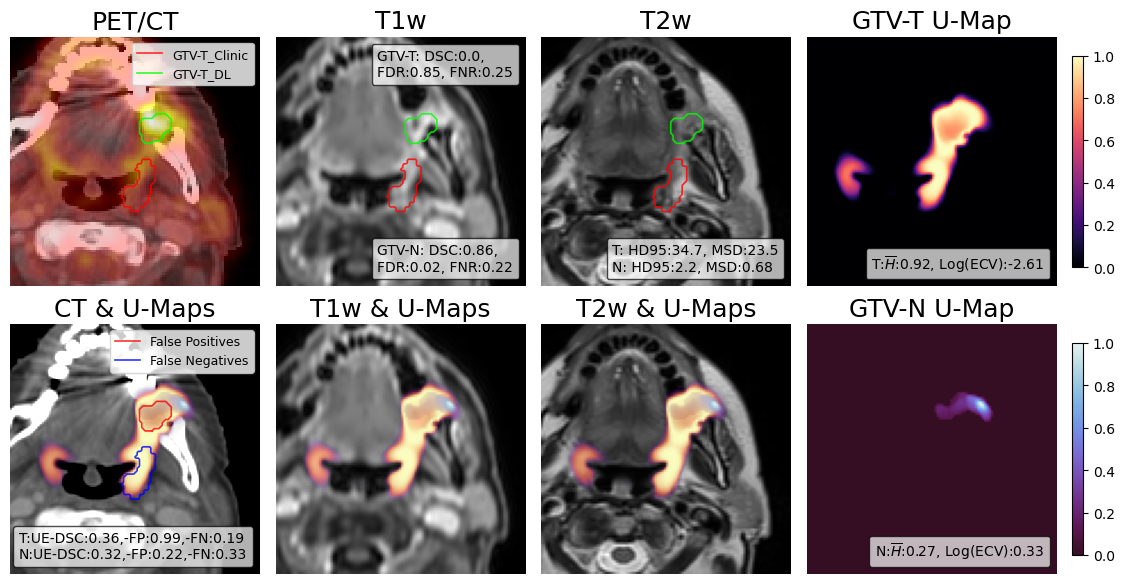

In [15]:

patient = 'HNCDL_095'
"""
    at1 = AnchoredText("GTV-T: DSC:0.0,\nFDR:0.85, FNR:0.25",
                  prop=dict(size=10), frameon=True,
                  loc='upper right',
                  )
    at1.patch.set_alpha(0.7)
    at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax1.add_artist(at1)

    at2 = AnchoredText("GTV-N: DSC:0.86,\nFDR:0.02, FNR:0.22",
                  prop=dict(size=10), frameon=True,
                  loc='lower right',
                  )
    at2.patch.set_alpha(0.7)
    at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax1.add_artist(at2)
    
    at3 = AnchoredText("T: HD95:34.7, MSD:23.5\nN: HD95:2.2, MSD:0.68",
                  prop=dict(size=10), frameon=True,
                  loc='lower right',
                  )
    at3.patch.set_alpha(0.7)
    at3.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax2.add_artist(at3)

    at4 = AnchoredText("T:$\overline{H}$:0.92, Log(ECV):-2.61",
                  prop=dict(size=10), frameon=True,
                  loc='lower right',
                  )
    at4.patch.set_alpha(0.7)
    at4.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax3.add_artist(at4)

    at5 = AnchoredText("T:UED:0.36,FPD:0.99,FND:0.19\nN:UED:0.32,FPD:0.22,FND:0.33",
                  prop=dict(size=10), frameon=True,
                  loc='lower right',
                  )
    at5.patch.set_alpha(0.7)
    at5.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax4.add_artist(at5)

    at9 = AnchoredText("N:$\overline{H}$:0.27, Log(ECV):0.33",
                  prop=dict(size=10), frameon=True,
                  loc='lower right',
                  )
    at9.patch.set_alpha(0.7)
    at9.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax7.add_artist(at9)

"""

img = load_images_labels(join(raw_data_path,'imagesTs'), join(raw_data_path,'labelsTs'), patient)
u_map = np.load(join(umap_path, patient+'.npz'))['umap']
seg = load_nii(join(seg_path, patient+'.nii.gz'))

slice_no = 152
bbox = [50, 160, 90, 200]
img_roi = img[:,slice_no, bbox[0]:bbox[1], bbox[2]:bbox[3]]
u_map_roi = u_map[:,slice_no, bbox[0]:bbox[1], bbox[2]:bbox[3]]
seg_roi = seg[slice_no, bbox[0]:bbox[1], bbox[2]:bbox[3]]

axial_img =[img_roi, u_map_roi, seg_roi]
sagittal_img = None
coronal_img = None
plot_uncertainty_maps(patient, axial_img, coronal_img, sagittal_img,  invert_y=False, save=True)

1.0 -0.0
[-1  0  1] (130, 130) (3,)
(5, 130, 130) (3, 130, 130) (130, 130)


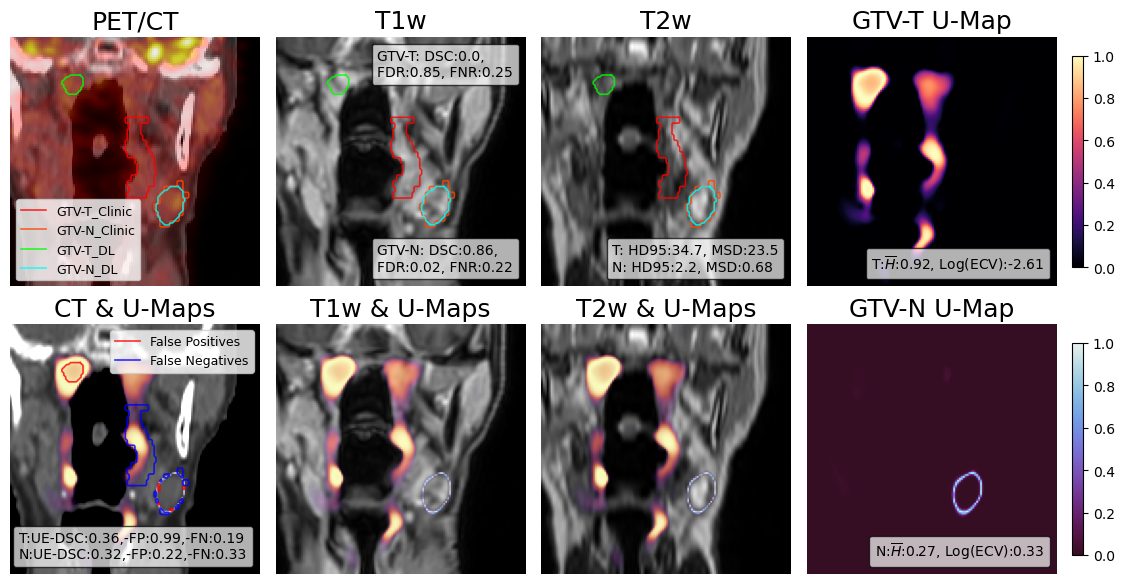

In [16]:
#slice_no = 98 #628
bbox = [80, 210, 80, 210]
slice_no = 119 # 095

img_roi = img[ :, bbox[0]:bbox[1],slice_no, bbox[2]:bbox[3]]
u_map_roi = u_map[:, bbox[0]:bbox[1],slice_no, bbox[2]:bbox[3]]
seg_roi = seg[ bbox[0]:bbox[1], slice_no, bbox[2]:bbox[3]]
coronal_img =[img_roi, u_map_roi, seg_roi]

axial_img=None
sagittal_img = None

plot_uncertainty_maps(patient, axial_img, coronal_img, sagittal_img,  invert_y=True, save=True)

1.0 -0.0
[-1  0  1] (130, 120) (2,)
(5, 130, 120) (3, 130, 120) (130, 120)


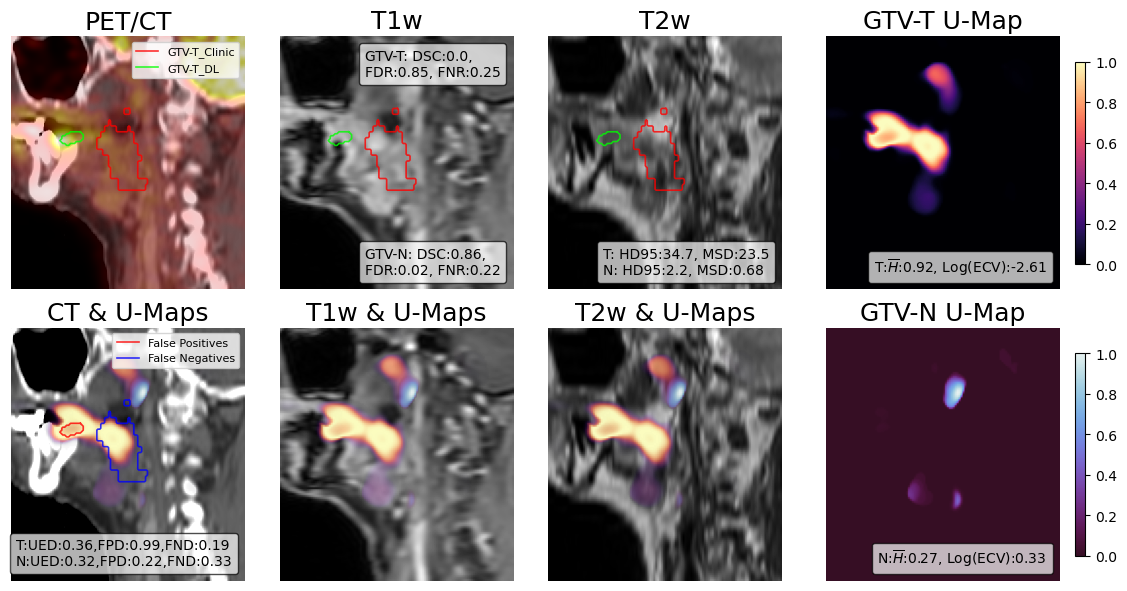

In [70]:
#slice_no = 98 #628
bbox = [75, 205, 60, 180]
slice_no = 149 # 095

img_roi = img[ :, bbox[0]:bbox[1], bbox[2]:bbox[3],slice_no]
u_map_roi = u_map[:, bbox[0]:bbox[1], bbox[2]:bbox[3],slice_no]
seg_roi = seg[ bbox[0]:bbox[1], bbox[2]:bbox[3], slice_no]
sagittal_img =[img_roi, u_map_roi, seg_roi]

axial_img=None
coronal_img  = None
plot_uncertainty_maps(patient, axial_img, coronal_img, sagittal_img,  invert_y=True, save=True)

1.0 -0.0
[-1  0  1] (110, 110) (3,)
(5, 110, 110) (3, 110, 110) (110, 110)


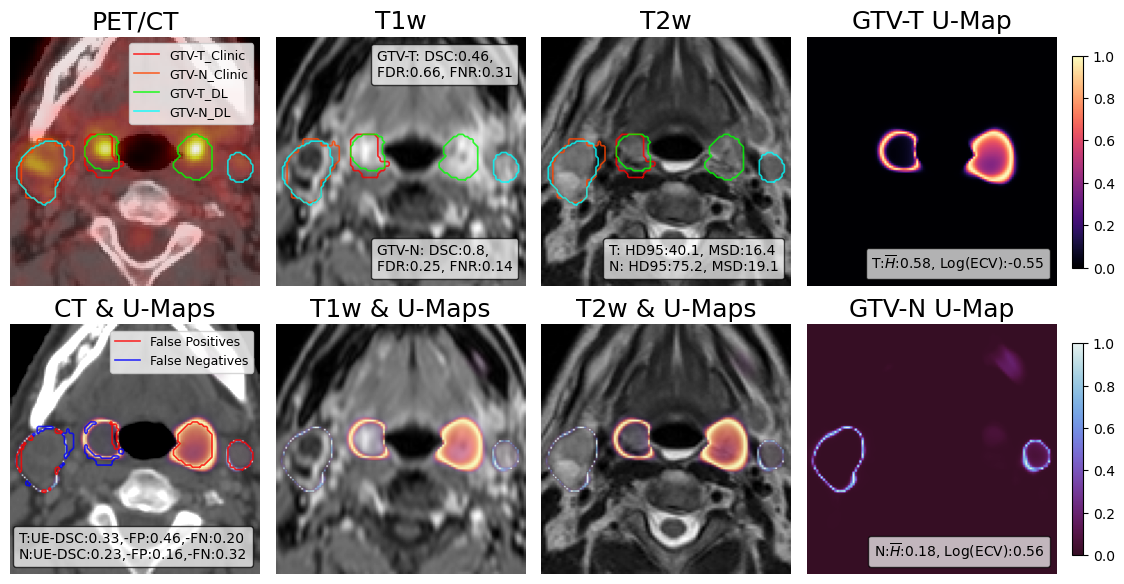

In [21]:
patient = 'HNCDL_628'
"""

    #save for later use 'HNCDL_628'
    # at1 = AnchoredText("GTV-T: DSC:0.46,\nFDR:0.66, FNR:0.31",
    #               prop=dict(size=10), frameon=True,
    #               loc='upper right',
    #               )
    # at1.patch.set_alpha(0.7)
    # at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    # ax1.add_artist(at1)

    # at2 = AnchoredText("GTV-N: DSC:0.8,\nFDR:0.25, FNR:0.14",
    #               prop=dict(size=10), frameon=True,
    #               loc='lower right',
    #               )
    # at2.patch.set_alpha(0.7)
    # at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    # ax1.add_artist(at2)
    
    # at3 = AnchoredText("T: HD95:40.1, MSD:16.4\nN: HD95:75.2, MSD:19.1",
    #               prop=dict(size=10), frameon=True,
    #               loc='lower right',
    #               )
    # at3.patch.set_alpha(0.7)
    # at3.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    # ax2.add_artist(at3)

    # at4 = AnchoredText("T:$\overline{H}$:0.58, Log(ECV):-0.55",
    #               prop=dict(size=10), frameon=True,
    #               loc='lower right',
    #               )
    # at4.patch.set_alpha(0.7)
    # at4.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    # ax3.add_artist(at4)

    # at5 = AnchoredText("T:UED:0.33,FPD:0.46,FND:0.20\nN:UED:0.23,FPD:0.16,FND:0.32",
    #               prop=dict(size=10), frameon=True,
    #               loc='lower right',
    #               )
    # at5.patch.set_alpha(0.7)
    # at5.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    # ax4.add_artist(at5)

    # at9 = AnchoredText("N:$\overline{H}$:0.18, Log(ECV):0.56",
    #               prop=dict(size=10), frameon=True,
    #               loc='lower right',
    #     
              )
    # at9.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    # ax7.add_artist(at9)
"""
img = load_images_labels(join(raw_data_path,'imagesTs'), join(raw_data_path,'labelsTs'), patient)
u_map = np.load(join(umap_path, patient+'.npz'))['umap']
seg = load_nii(join(seg_path, patient+'.nii.gz'))

slice_no = 160
bbox = [45, 155, 90, 200]
img_roi = img[:,slice_no, bbox[0]:bbox[1], bbox[2]:bbox[3]]
u_map_roi = u_map[:,slice_no, bbox[0]:bbox[1], bbox[2]:bbox[3]]
seg_roi = seg[slice_no, bbox[0]:bbox[1], bbox[2]:bbox[3]]

axial_img =[img_roi, u_map_roi, seg_roi]
sagittal_img = None
coronal_img = None
plot_uncertainty_maps(patient, axial_img, coronal_img, sagittal_img ,invert_y=False, save=True )

1.0 -0.0
[-1  0  1] (145, 145) (3,)
(5, 145, 145) (3, 145, 145) (145, 145)


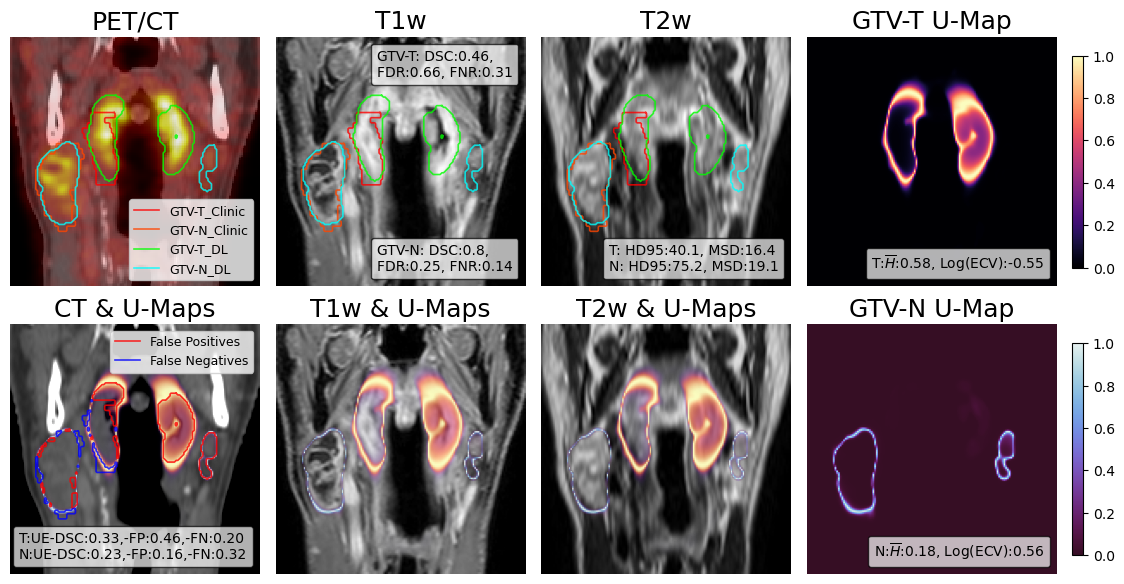

In [22]:
patient = 'HNCDL_628'

slice_no = 98
bbox = [85, 230, 75, 220]

img_roi = img[ :, bbox[0]:bbox[1],slice_no, bbox[2]:bbox[3]]
u_map_roi = u_map[:, bbox[0]:bbox[1],slice_no, bbox[2]:bbox[3]]
seg_roi = seg[ bbox[0]:bbox[1], slice_no, bbox[2]:bbox[3]]
coronal_img =[img_roi, u_map_roi, seg_roi]
axial_img = None #[img_roi, u_map_roi, seg_roi]
sagittal_img = None

plot_uncertainty_maps(patient, axial_img, coronal_img, sagittal_img ,invert_y=True, save=True )